# Evaluating Signal Acquisition Frontends for Compressed Sensing Applications using Open Source Software

<img style="float: right;" src="figures/tui-small.png" width=300>

**Christoph Wagner**

Electronic Measurements and Signal Processing Group  
Technische Universität Ilmenau

<sub>_Support material on the EuroSciPy 2018 poster_

# Introduction

We show how to model a signal-aquisition frontend with joint reconstruction of the sparsely sampled data in python. Along the ride we will hit topics such as modelling control loops, data-series resampling, digital logic simulation, algebraic modelling of transformations and sparse signal reconstruction.

To model control loops we will use `bmspy`, a block model simulator for python. Data-series handling will be achieved with `numpy` and resampling is done with `scipy`. For algebraic modelling and sparse signal recovery we will employ `fastmat`, a linear algebra package for handling (very) large structured matrices in python efficiently.

The signal flow diagram indicates the processing stages neccessary to tackle our problem and also guides through the presentation:


<p align="center">
    <img src="figures/signal-flow.png" width=600>
</p>

In [1]:
import numpy as np

from scipy import interpolate as sint
from scipy import sparse as sps

import fastmat as fm

from matplotlib.pyplot import *
%matplotlib notebook

import bms
from bms.signals.functions import *
from bms.blocks.continuous import *
from bms.blocks.nonlinear import *

matplotlib.rcParams['figure.figsize'] = (6., 5.5)

## Mechanic Modelling of Rotor Drive

We want to model this physical process which outputs a time-series of rotor shaft angle values including the dynamics of the motor drive control as well as external perturbation forces:

<p align="center">
    <img src="figures/physical-model.png" width=800>
</p>

Let's start by defining the general parameter for the model and the to-be-modelled shaft imbalance:

In [2]:
Wset                    = 50.       # desired rotational speed
W0                      = 0.        # initial rotational speed

Umax                    = 24.       # Supply voltage of motor controller
Imax                    = 1.2       # Maximum supply power of motor controller
Uc0                     = 0.        # Initial voltage command
R                       = 1.0       # Resistance of motor current path
L                       = 0.02      # Inductance of motor current path
J                       = 0.001     # Mass moment of inertia of shaft
k                       = 0.2
Tr                      = 0.1       # Friction torque of shaft arrangement
Tdis                    = 0.2       # Amount of disturbance torque

imbalance_mass          = 0.001     # 1 gram
imbalance_distance      = 0.01      # 1 cm
imbalance_angle         = 123.0     # 30 degree

num_sensor_snr          = -10.      # signal-to-noise ratio for force sensor signal
num_sensor_translation  = 10.       # translation scaling of force to sensor output

Now define the variables we will use (the edges of the model graph)

In [3]:
Wc   = Step(('Rotational speed command', 'wc'), Wset)
Wd   = bms.Variable(('delta rotational speed', 'Wd'))
W    = bms.Variable(('Rotational speed [Revs / sec]', 'w'), (W0,))
Rabs = bms.Variable(('Rotational angle [Revs]', 'Rabs'))

Uc   = bms.Variable(('Voltage Command','Uc'), (Uc0,))
Um   = bms.Variable(('Voltage Command Motor','Um'))
e    = bms.Variable(('Counter Electromotive Force', 'Ue'))

Uind = bms.Variable(('Voltage Inductor','Vi'))
Iset = bms.Variable(('Intended Inductor Intensity', 'Iset'))
Iind = bms.Variable(('Actual Inductor Intensity','Ii'))

Tm   = bms.Variable(('Motor torque','Tm'))
Tfri = bms.Variable(('Friction torque','Tf'))
Tn   = bms.Variable(('Rotational noise torque', 'Tn'))
Td   = bms.Variable(('Rotational disturbance torque', 'Td'))
T    = bms.Variable(('Total Torque','T'))

## Specify the Dynamic System

model the dynamic system simply as a list of Blocks while specifying the individual blocks' input and output signals using the just defined variables.

In [4]:
Runtime, Rate = 5., 500.    # Simulation length and samples per secons
system = bms.DynamicSystem(Runtime, int(Runtime * Rate), [
    # Control input value
    Subtraction(Wc, W, Wd),
    ODE(Wd, Uc, [10., 0.1], [0, 10., 0.5]),
    Saturation(Uc, Um, -Umax, Umax),
    
    # Determine Motor current considering back-EMF
    Gain(W, e, k),
    Subtraction(Um, e, Uind),
    ODE(Uind, Iset, [1], [R, L]),
    Saturation(Iset, Iind, 0, Imax),
    
    # Determine motor torque and bearing friction
    Gain(Iind, Tm, k),
    Coulomb(Tm, W, Tfri, Tr, 1),
    
    # Model mechanic perturbation
    FunctionBlock(
        Tn, Tn, lambda x: (np.random.normal(0., Tdis, x.shape) / Wset)),
    Product(W, Tn, Td),
    
    # Determine total torque and translate to rotational speed and -angle
    Sum([Tm, Tfri, Td], T),
    ODE(T, W, [1], [0, J]),
    ODE(W, Rabs, [1], [0, 1])    
])

Actual simulation is as simple as calling

In [5]:
system.Simulate()

And accessing the result data may be achieved by accessing the `values`field of any variable:

In [6]:
print(W.values)

[ 0.00000000e+00 -3.17308995e-31 -2.54319049e-31 ...  4.93797511e+01
  4.96224846e+01  5.01955089e+01]


## Plot the Result Data of the System Simulation

In [7]:
system.PlotVariables([[Wd, W], [Um, e, Uind], [Iset, Iind, Tm, Tfri]])
tight_layout()

<IPython.core.display.Javascript object>

# Modelling the Input Signals Uniformly

## Specify a unified sample grid in angular-domain

As we want to measure a parameter residing in the angular dimension of shaft-rotation it is a desireable intention to actually work in the angular domain. The incremental encoder translates angular movement in a series of incremental pulses and provides a reference signal in the actually desired domain. So we also want to stick to that domain as close as possible. Therefore we resample the equidistant time-series data to an equidistant angular grid (based on the actual shaft angles we determined during the physical simulation).

As the integration and sampling required by the signal acquisition stages require a sub-step resolution we need to interpolate the angular grid a bit further to leave some room for signalling and integration taking place in sub-angular-step resolution. Based on the new angular grid we define a time-series support that represents the equidistant angular grid over the simulated shaft angle.

As we generate the mixing sequence based on a edge-driven logic fed by a clock derived from the incremental encoder signals themselves, we see that our logic states only change in relatively few time instances throughout the observed signal duration. We remember these clock transition edges as our fourth support grid, upon which we progress the logic signals.

To bring all these signals together we need to resample signals between these four grids, considering their special properties appropriately, when necessary.

**But first,** let's define some constants used in this section:

In [8]:
num_pulses_per_rev      = 500         # pulses per revolution of incremental encoder
num_interpolation       = 10          # interpolate each tick 20-fold
num_input_fullrange     = 10.00       # input signal range if -10V ... 10V

Talking about interpolation, we now generate the second grid, the equidistant-angular grid, based on the equidistant-time grid from physical modelling by resampling. The angular grid is already interpolated with the interpolation factor just specified such that one pulse from the incremental encoder will be interpolated into a number of uniformely-spaced intermediate angles.

In [9]:
# define an interpolator base class
def splineInterpolate(vecX, vecY, newX):
    """Wrapper around scipy.interpolate.InterpolatedUnivariateSpline"""
    return sint.InterpolatedUnivariateSpline(vecX, vecY)(newX)

# fetch revolution and speed signal from simulation and extract timebase from it
vec_mech_rev = Rabs.values
vec_mech_speed = W.values
vec_timebase = np.linspace(
    0, Runtime, len(vec_mech_rev), endpoint=True
)

# define a sufficient precision to work on
vec_timebase_interpolated = np.linspace(
    0, Runtime, int(Wset * num_pulses_per_rev * num_interpolation) + 1, endpoint=True
)
num_timebase_stepping = np.asscalar(np.diff(vec_timebase_interpolated[:2]))


# interpolate the revolution angle timeseries to the more precise timebase
vec_mech_rev_interpolated = splineInterpolate(
    vec_timebase, vec_mech_rev,
    vec_timebase_interpolated
)

# interpolate the revolution angle timeseries to the more precise timebase
vec_mech_speed_interpolated = splineInterpolate(
    vec_timebase, vec_mech_speed,
    vec_timebase_interpolated
)

## Deriving Timestamps from the Angular Grid

As we have interpolated in a completely different domain (angles) we now need to identify the precise timestamps when we hit the exact values from the angular grid to deduct a sufficient basis for time-domain integration required later on.

In [10]:
# now retrieve a timebase for fixed angles on which we will center the digital signals
# (we use the incremental encoder signals as clock)
# The angular resolution is given by the number of pulses per revolution (parameter of
# the incremental encoder used) and the desired interpolation factor
angular_resolution = num_pulses_per_rev * num_interpolation

# generate an angular support array spanning the revolution range found in the mechanical
# simulation
vec_angles = np.arange(
    np.floor(vec_mech_rev_interpolated.max()
             * num_pulses_per_rev
             * num_interpolation)) / angular_resolution
num_angles = len(vec_angles)

as we want to find the time support where the observed angular function hits the angular
grid precisely we need to interpolate. We assume both the angular funtion in time-domain
as well as the new angular support are both monotonically growing. Then we are able to
perform linear interpolation between two adjacent angular points.

This may be achieved by:   
  1. constructing an indexiung array `loc`, which holds the corresponding index into
     the angle time-series, whose value is closest -- but still smaller -- than the
     required angular support value.
  2. Determine the angular gradient and sampling interval of the time series.
  3. Based on the relative angle difference and the relative gradient it is possible
     to determine a correction factor to the time support values. By utilizing the
     `loc` index array it is possible to vectorize these operations, saving a
     considerable amount of expensive loop iteration work

In [11]:
index = 0
vec_angles_timebase = np.zeros(*(vec_angles.shape))
vec_loc = np.zeros(*(vec_angles.shape), dtype=int)
for idx, angle in np.ndenumerate(vec_angles):
    while vec_mech_rev_interpolated[index + 1] < angle:
        index +=1
    vec_loc[idx] = index

vec_angles_timebase = vec_timebase_interpolated[vec_loc] + (
    (vec_angles - vec_mech_rev_interpolated[vec_loc])
    * num_timebase_stepping
    / np.diff(vec_mech_rev_interpolated)[vec_loc]
)

## Incremental Encoder Signal Generation

In [12]:
# define a vector mapping the rotation angle to an incremental encoder state
vec_state = vec_angles * angular_resolution // num_interpolation

# now generate the logic states of the incremental encoder
vec_signal_Y = (vec_state % 4) >= 2
vec_signal_X = np.logical_xor((vec_state % 2) >= 1, vec_signal_Y)
vec_signal_Z = (vec_state % num_pulses_per_rev) < 2;

# then derive the CLK signal and detect its edges
vec_signal_CLK = np.logical_xor(vec_signal_X, vec_signal_Y)
vec_signal_edges = np.logical_and(
    np.logical_not(np.roll(vec_signal_CLK, 1)), vec_signal_CLK)

# these edges will be used during logic processing
vec_logic_edges = np.concatenate((np.array([0]), np.where(vec_signal_edges)[0]))
num_logic_edges = len(vec_logic_edges)
vec_logic_timebase = vec_angles_timebase[vec_logic_edges]
vec_logic_state = vec_state[vec_logic_edges].astype(int)

## Incremental encoder signal generation

In [13]:
default_interval = (Runtime - 0.01, Runtime)

def plot_signal(signal, dy, plot_interval=default_interval):
    plot_range = np.logical_and(vec_angles_timebase >= plot_interval[0],
                                vec_angles_timebase <= plot_interval[1])
    return vec_angles_timebase[plot_range], dy + 0.5 + 0.8 * signal[plot_range]

def plot_logic(signal, dy, plot_interval=default_interval):
    plot_range = np.logical_and(vec_logic_timebase >= plot_interval[0],
                                vec_logic_timebase <= plot_interval[1])
    return vec_logic_timebase[plot_range], dy + 0.5 + 0.8 * signal[plot_range]

def show_plot():
    f, p1 = subplots(1, 1)
    interval = (0.171, 0.176)
    p1.step(*plot_signal(vec_signal_Z - 0.5, 0, interval), label='Z');
    p1.step(*plot_signal(vec_signal_X - 0.5, 1, interval), label='X');
    p1.step(*plot_signal(vec_signal_Y - 0.5, 1, interval), label='Y');
    p1.axes.yaxis.grid(True)
    p1.set_ylim(0,2)
    p1.legend(loc='lower right')

In [14]:
show_plot()

<IPython.core.display.Javascript object>

## Force Sensor Signal Generation

The force sensor output signals represent the perpendicular forces found in the shafts' bearings and can be modelled as sinusoid harmonics of the imbalance angle and intensity as well as the shaft's angular rotation function.

In [15]:
# determine force signal inputs 
vec_mech_force = num_sensor_translation * imbalance_mass * imbalance_distance * vec_mech_speed_interpolated ** 2
vec_mech_force_i = np.multiply(
    vec_mech_force,
    np.cos(2 * np.pi * vec_mech_rev_interpolated + imbalance_angle * np.pi / 180)
)
vec_mech_force_q = np.multiply(
    vec_mech_force, 
    np.sin(2 * np.pi * vec_mech_rev_interpolated + imbalance_angle * np.pi / 180)
)

We also want to consider noise produced by the force sensors and input amplifiers

In [16]:
# now add some noise
def add_noise (data, num_SNR):
    """
    Generate noise with a certain norm and add it to the input data.
    
    input parameters:
        data : data vector to add noise to
        num_SNR : signal to noise ratio in dB
    """
    return data + (np.random.randn(*data.shape) / np.sqrt(data.size)
                   * np.linalg.norm(data) / 10 **(np.float(num_SNR) / 20))

vec_mech_I = add_noise(vec_mech_force_i, num_sensor_snr)
vec_mech_Q = add_noise(vec_mech_force_q, num_sensor_snr)

Now we resample the force signal directly to the time-domain grid specified at equidistant angular position. This way the time-domain characteristics of the force signal, which was generated in the equidistant time-domain grid from physical modelling, are preserved.

In [17]:
# resample the force singals into the angles-timebase
vec_signal_I = splineInterpolate(
    vec_timebase_interpolated, vec_mech_I,
    vec_angles_timebase
)
vec_signal_Q = splineInterpolate(
    vec_timebase_interpolated, vec_mech_Q,
    vec_angles_timebase
)

## Force Sensor Signal Generation

In [18]:
def show_plot():
    f, p1 = subplots(1, 1)
    interval = (4.8, 5.)
    p1.plot(*plot_signal(vec_signal_I / num_input_fullrange, 2, interval), label='Force I');
    p1.plot(*plot_signal(vec_signal_Q / num_input_fullrange, 1, interval), label='Force Q');
    p1.step(*plot_signal(vec_signal_Z - 0.5, 0, interval), label='Z');
    p1.axes.yaxis.grid(True)
    p1.set_ylim(0, 3)
    p1.legend(loc='lower right')

In [19]:
show_plot()

<IPython.core.display.Javascript object>

# Modelling of Signal Acquisition Frontend

# Modelling of Signal Acquisition Frontend

The following block diagram shows the processing operations that are applied to the input signals in order to obtain the sampled data:

<p align="center">
    <img src="figures/acquisition-model.png" width=600>
</p>

Following, we specify the necessary parameters controlling the blocks' behaviour:

In [20]:
# parameters
num_revs_per_frame      = 17
num_integration_width   = 25
mat_lfsr                = fm.LFSRCirculant(12, 83)

num_adc_fullrange       = 2.048       # ADC range is -2048mV ... 2048mV
num_integrator_taudis   = 1e-4        # Discharge time constant

num_min_revs_per_sec    = 10          # Minimal 1 revolution per second
num_integrator_scale    = (num_adc_fullrange / num_input_fullrange) * num_min_revs_per_sec * num_pulses_per_rev

In [21]:
# compute some constants and 
num_chips_per_rev = num_pulses_per_rev // 2
num_chips_per_frame = num_chips_per_rev * num_revs_per_frame
num_samples_per_frame = num_chips_per_frame // num_integration_width

# verify that the parameters are sane
#assert(num_revs_per_frame)
assert num_pulses_per_rev == num_chips_per_rev * 2
if num_chips_per_frame != num_samples_per_frame * num_integration_width:
    raise AssertionError(("Choose the integration width (%d) such that a non-fractional frame sample count"
                          "is achieved for num_chips_per_frame (%d).") %(num_integration_width, num_chips_per_frame))

## Determine logic signals

Many operations of the signal acquisition frontend are controlled by logic signals which may be easily evaluated by the built-in support for boolean vector operations in `numpy`. However, we need to make sure we only propagate logic signals in clock signal edges. That's why we extracted clock edges earlier and extracted a (smaller) secondary timebase to rely logic signals upon. Basically this resembles a very simple logic signal simulator.

In [22]:
# now we are able to compute the logical behaviour as in the timing diagrams
vec_logic_chip = vec_logic_state // 2

vec_logic_CNT = vec_logic_chip // num_chips_per_rev % num_revs_per_frame
vec_logic_CNT_SAMPLE = vec_logic_chip % num_chips_per_frame // num_integration_width
vec_logic_SELECT = vec_logic_CNT_SAMPLE % 2
vec_logic_DISCHARGE = (
    (vec_logic_chip % num_chips_per_frame + 1) % num_integration_width > 3
)
vec_logic_SAMPLE = (
    (vec_logic_chip % num_chips_per_frame) % num_integration_width == 1
)
vec_logic_RESET = (
    vec_logic_chip % num_chips_per_frame < 2
)

vec_sequence_frame = np.tile(
    mat_lfsr[:, 0], int(np.ceil(num_chips_per_frame / mat_lfsr.numN))
)[:num_chips_per_frame]
vec_logic_SEQ = np.tile(
    vec_sequence_frame, int(np.ceil(num_logic_edges / num_chips_per_frame))
)[:num_logic_edges]

## Implement Mixing and Integration Operation

As we have all the input signals (force and incremental encoder) as well as the generated logic signals, we are now able to implement the mix-and-integrate operation. Before we can do that, we need to translate the generated logic signals back to the signals' sampling grid, shich we can achieve with the following function:

In [23]:
# move the logic signals back to the angular time grid
def convert_to_angular(logic_signal):
    cnt = len(vec_angles_timebase)
    output = np.zeros(cnt, dtype=int)
    index = 0
    for ii, value in np.ndenumerate(logic_signal):
        timestamp = vec_logic_timebase[ii]
        while vec_angles_timebase[index] <= timestamp:
            output[index] = value
            index += 1
            if index == cnt:
                return output
    output[index:] = value
    return output

As all signals are on a unified sampling grid we are able to use simple vector algebra operations as provided by `numpy`.

In [24]:
vec_signal_SEQ = convert_to_angular(vec_logic_SEQ)
vec_signal_SELECT = convert_to_angular(vec_logic_SELECT)
vec_signal_SAMPLE = convert_to_angular(vec_logic_SAMPLE)
vec_signal_DISCHARGE = convert_to_angular(vec_logic_DISCHARGE)

# Mixing operation: Flip the input signals when SEQ = 1
vec_signal_Imix = np.multiply(vec_signal_SEQ, vec_signal_I)
vec_signal_Qmix = np.multiply(vec_signal_SEQ, vec_signal_Q)

However, as the underlying sampling grid is non-equidistant we need to consider the actual timestamp information during the actual integration, which we will approximate with trapezoid integration.

In [25]:
# Integrate over the mixed signal
def piecewise_integrate(timebase, signal):
    arr_timebase = np.empty((2, len(timebase) - 1), dtype=timebase.dtype)
    arr_timebase[0, :] = timebase[:-1]
    arr_timebase[1, :] = timebase[1:]
    
    arr_signal = np.empty((2, len(signal) - 1), dtype=signal.dtype)
    arr_signal[0, :] = signal[:-1]
    arr_signal[1, :] = signal[1:]
    
    return num_integrator_scale * np.concatenate(
        (np.array([0]), np.trapz(arr_signal, x=arr_timebase, axis=0)))
    
vec_Iint = piecewise_integrate(vec_angles_timebase, vec_signal_Imix)
vec_Qint = piecewise_integrate(vec_angles_timebase, vec_signal_Qmix)

In [26]:
arr_signal_Iint = np.zeros((len(vec_angles_timebase), 2), dtype=float)
arr_signal_Qint = np.zeros((len(vec_angles_timebase), 2), dtype=float)
for idx in range(len(vec_angles_timebase) - 1):
        idx_integrate = (1 if vec_signal_SELECT[idx] > 0 else 0)
        idx_dump = (0 if vec_signal_SELECT[idx] > 0 else 1)
        
        arr_signal_Iint[idx + 1, idx_integrate] = (
            arr_signal_Iint[idx, idx_integrate] + vec_Iint[idx])
        arr_signal_Qint[idx + 1, idx_integrate] = (
            arr_signal_Qint[idx, idx_integrate] + vec_Qint[idx])
        
        if vec_signal_DISCHARGE[idx] > 0:
            decay = np.exp(-(vec_angles_timebase[idx + 1]
                             - vec_angles_timebase[idx])
                           / num_integrator_taudis)
            arr_signal_Iint[idx + 1, idx_dump] = (
                arr_signal_Iint[idx, idx_dump] * decay)
            arr_signal_Qint[idx + 1, idx_dump] = (
                arr_signal_Qint[idx, idx_dump] * decay)
        else:
            arr_signal_Iint[idx + 1, idx_dump] = arr_signal_Iint[idx, idx_dump]
            arr_signal_Qint[idx + 1, idx_dump] = arr_signal_Qint[idx, idx_dump]

vec_signal_Iint = np.where(vec_signal_SELECT > 0,
                           arr_signal_Iint[:, 0], arr_signal_Iint[:, 1])
vec_signal_Qint = np.where(vec_signal_SELECT > 0,
                           arr_signal_Qint[:, 0], arr_signal_Qint[:, 1])

In [27]:
def show_plot():
    f, p1 = subplots(1, 1)
    interval = (4.950, 4.956)
    p1.plot(*plot_signal(vec_signal_Iint / num_adc_fullrange, 4, interval))
    p1.plot(*plot_signal(vec_signal_Qint / num_adc_fullrange, 4, interval), label='Integrated I/Q')
    p1.step(*plot_signal(vec_signal_SELECT - 0.5, 3, interval), label='SELECT')
    p1.step(*plot_signal(0.5 * vec_signal_SAMPLE - 0.25, 3, interval), label='SAMPLE')
    p1.step(*plot_signal(0.5 * vec_signal_DISCHARGE - 0.25, 3, interval), label='DISCHARGE')

    p1.plot(*plot_signal(vec_signal_Imix / num_input_fullrange, 2, interval));
    p1.plot(*plot_signal(vec_signal_Qmix / num_input_fullrange, 2, interval), label='Mixed I/Q');
    p1.step(*plot_signal(0.5 * vec_signal_SEQ, 1, interval), label='SEQ')
    p1.plot(*plot_signal(vec_signal_I / num_input_fullrange, 0, interval));
    p1.plot(*plot_signal(vec_signal_Q / num_input_fullrange, 0, interval), label='Force I/Q');
    p1.axes.yaxis.grid(True)
    p1.set_ylim(0, 5)
    p1.legend(loc='lower right')

## Internal Signals of Acquisition Frontend

Show the digital and analogue signals found in the acquisition stage as defined by the block model.

In [28]:
show_plot()

<IPython.core.display.Javascript object>

# Data Conversion, Algebraic Modelling and Reconstruction

# Data Conversion, Algebraic Modelling and Reconstruction

Now that we have processed the force signals in the analogue domain we need to sample the just generated integrator block output and convert it into the digital domain. This can be achieved employing an Analog-to-Digital Converter (ADC), which itself introduces a fixed quantization and some errors. To get sensible results we model quantization by specifying the quantization width of the converter register and model additional errors by additional white noise limited by the *effective number of bits* metric, which essentially reduces the ADC error model to an equivalent number of trustworthy bits after the conversion. You may also think of it as an indicator on how badly noise, nonlinearities, DC- and quantization errors impede converter performance

In [29]:
# define some parameters
num_adc_quantization    = 14          # ADC bits
num_adc_ENOB            = 12          # useful ADC bits
num_overtones           = 10          # number of harmonics to process

## ADC Quantization

In [30]:
def adc_sample(signal):
        vec_sampling = np.where(np.logical_and(vec_signal_SAMPLE > 0, vec_signal_edges > 0))[0]
        
        return (np.clip((signal[vec_sampling] / num_adc_fullrange
                        + (np.random.randn(*vec_sampling.shape)
                           * 2 ** (-num_adc_ENOB + 1) # assume symmetric range in ENOB
                          )
                        ), -1., 1.)
                * 2 ** (num_adc_quantization - 1)
                ).astype(int)

vec_digital_I = adc_sample(vec_signal_Iint)
vec_digital_Q = adc_sample(vec_signal_Qint)

# put the sampled data into data frames
num_frames = len(vec_digital_I) // num_samples_per_frame
arr_digital = (vec_digital_I[: num_samples_per_frame * num_frames].reshape((num_samples_per_frame, -1), order='F') +
               vec_digital_Q[: num_samples_per_frame * num_frames].reshape((num_samples_per_frame, -1), order='F') * 1j)

## Algebraic Modelling of the Acquisition Frontend


In [31]:
# Define a Fourier Matrix representing the signal base
F = fm.Partial(fm.Fourier(num_chips_per_rev), N=np.arange(num_overtones + 2))

# Define a Measurement representing our analogue compression scheme
# as the integrators deliver the integration data one sample delayed, compensate for that
# by shifting the rows of P by one integration window
P = fm.Sparse(sps.coo_matrix(
    (vec_sequence_frame,
     (np.roll(np.arange(num_chips_per_frame) // num_integration_width, -num_integration_width),
      np.arange(num_chips_per_frame) % num_chips_per_rev)),
    dtype=np.int8
))

# compose a preliminary system matrix and determine a main diagonal gain correction factor
A_hat = (P * F.H).gram
D = fm.Diag(np.sqrt(1. / np.abs(np.diag(A_hat * np.eye(A_hat.numN)))))

# now compose the actual system matrix
A = P * F.H * D

## Insights into our System Matrix

Now look at the algebraic structure of our matrices and take a closer look at the mutual coherence of the system matrix, which is a crucial parameter for sparse signal recovery performance.

In [32]:
arr_mu_coh = np.divide(np.abs(A.gram.array), np.diagonal(np.abs(A.gram.array))) - np.eye(A.gram.numN)
print("Mutual Coherence of the gramian of A: %.3f at position %s" %(
    arr_mu_coh.max(), str(np.unravel_index(arr_mu_coh.argmax(), arr_mu_coh.shape))
))

Mutual Coherence of the gramian of A: 0.124 at position (5, 11)


In [33]:
def show_plot():
    f, ((p1, p2), (p3, p4)) = subplots(2, 2)
    p1.imshow(np.abs(A.array), aspect='auto')
    p1.title.set_text('System Matrix A')
    p2.imshow(P.array, aspect='auto')
    p2.title.set_text('Measurement Matrix P')
    p3.imshow(np.abs(A.gram.array), aspect='auto')
    p3.title.set_text('Gramian of A = A.H * A')
    p4.imshow(arr_mu_coh, aspect='auto')
    p4.title.set_text('Mutual Coherence Map')
    tight_layout()

In [34]:
show_plot()

<IPython.core.display.Javascript object>

## Reconstruction using OMP

Perform Sparse signal recovery using the `fastmat` implementation of Orthogonal Matching Pursuit (OMP) with the just modelled algebraic model of our acquisition frontend. The advantage of this will unfold as soon as the algebraic model grows in dimension as performing algebraic modelling with `fastmat` enables to efficiently exploit matrix structure in storage and computation.

In [35]:
# OMP Reconstruction

num_averages = 1
arr_digital_avg = arr_digital[:, :num_averages * (arr_digital.shape[1] // num_averages)]
arr_digital_avg = np.average(arr_digital.reshape((arr_digital.shape[0], -1, num_averages)), axis=2)

arr_reconstruction = fm.algs.OMP(A, arr_digital_avg, 1)

arr_reco_angles = np.angle(arr_reconstruction) * 180 / np.pi
arr_reco_magnitude = np.abs(arr_reconstruction)
vec_result_angles = arr_reco_angles[1,:]
vec_result_magnitude = arr_reco_magnitude[1, :]

In [42]:
def show_plot():
    f, ((p1, p2), (p3, p4), (p5, p6)) = subplots(3, 2, sharex=True)
    p1.imshow(arr_digital_avg.real, aspect='auto')
    p1.set_title('Sampled data (real)')
    p2.imshow(arr_digital_avg.imag, aspect='auto')
    p2.set_title('Sampled data (imag)')
    p3.imshow(np.abs(arr_reconstruction), aspect='auto')
    p3.set_title('Reconstruction (magnitude)')
    p4.imshow(np.angle(arr_reconstruction) * 180 / np.pi, aspect='auto')
    p4.set_title('Reconstruction (angles)')
    p5.plot(vec_result_magnitude)
    p5.set_title('Fundamental magnitude')
    p5.set_ylim(0, vec_result_magnitude.max() * 1.1)
    p6.plot(vec_result_angles)
    p6.plot([0, arr_reco_angles.shape[1] - 1], [imbalance_angle, imbalance_angle], color='k', linestyle='--', linewidth=1)
    p6.text(11.5, 112, 'avg: %.2f'% (np.average(arr_reco_angles[1,:]), ), fontsize=12, ha='right', va='top')
    p6.text(11.5, 104, 'sd: %.2f'% (np.std(arr_reco_angles[1,:]), ), fontsize=12, ha='right', va='top')
    p6.set_ylim(90, 150)
    p6.set_xlim(0, arr_reco_angles.shape[1] - 1)
    p6.set_title('Fundamental angle')
    tight_layout()

# Results

<IPython.core.display.Javascript object>


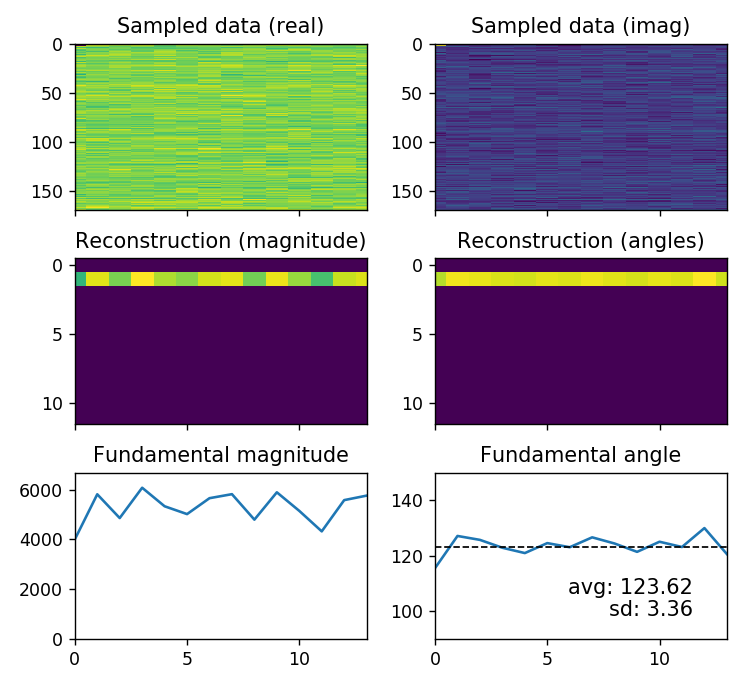

In [43]:
show_plot()

In [44]:
from matplotlib import rcParams, gridspec, colors, ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

# define colors
tuiBlue     = '#003366'
tuiOrange   = '#FF6600'
tuiRed      = '#CC0000'
tuiWhite    = '#FCF1F1'

# define colormaps
cmWOB = colors.LinearSegmentedColormap.from_list(
    "", [tuiWhite, tuiOrange, tuiBlue])
cmBWO = colors.LinearSegmentedColormap.from_list(
    "", [tuiOrange, tuiWhite, tuiBlue])

def plotMatrix(ax, arr, **options):
    cmap = options.get('cmap', cmWOB)
    clim = options.get('clim', (arr.min(), arr.max()))
    cbSteps = options.pop('cbSteps', 5)
    xbins = options.pop('xbins', 6)
    ybins = options.pop('ybins', 6)

    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=xbins))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=ybins))
    im = ax.imshow(arr, cmap=cmap, clim=clim, aspect='auto')
    div = make_axes_locatable(ax)
    cax = div.append_axes("right", size=0.1, pad=0.05)
    #    formatter = mpt.FuncFormatter(
#        lambda x, p: ("$1 \phase{%.0f^{\circ}}$" %(x)))
    cbar = colorbar(im, cax=cax)#, format=formatter)

    steps = np.linspace(clim[0], clim[1], cbSteps)
    cbar.set_ticks(steps)
    cbar.ax.set_yticklabels([r'$%d$' %(x, ) for x in steps])

    return cbar

In [45]:
def show_plot():
    f, ((p1, p2), (p3, p4)) = subplots(2, 2)
    cbar = plotMatrix(p1, P.array, clim=(-1, 1), cbSteps=3, cmap=cmBWO, xbins=4)
    cbar.ax.set_yticklabels(['-1', '0', '+1'])
    p1.title.set_text('Measurement matrix P')
    tight_layout()

    cbar = plotMatrix(p2, np.abs(arr_digital), clim=(0, 1000), cbSteps=5)
    cbar.ax.set_yticklabels(['0', '.25', '.50', '.75', '1'])
    p2.set_ylabel('Sample index')
    p2.set_xlabel('Time frame')
    p2.title.set_text('Measurement Vector s')
    tight_layout()

    cbar = plotMatrix(p3, arr_reco_angles, clim=(0, 180), cbSteps=5)
    cbar.ax.set_yticklabels(['0', '45', '90', '135', '180'])
    p3.set_ylabel('Harmonic')
    p3.set_xlabel('Time frame')
    p3.title.set_text('Reconstructed angles')
    tight_layout()

    p4.plot(arr_reco_angles[1,:], color=tuiOrange, label='angle')
    p4.plot([0, arr_reco_angles.shape[1] - 1], [imbalance_angle, imbalance_angle], color=tuiOrange, linestyle='--', linewidth=1)
    p4.text(11.5, 110, 'avg: %.2f'% (np.average(arr_reco_angles[1,:]), ), fontsize=12, ha='right', va='top')
    p4.text(11.5, 90, 'sd: %.2f'% (np.std(arr_reco_angles[1,:]), ), fontsize=12, ha='right', va='top')
    p4.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=8))
    p4.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=6))
    p4.set_ylim(0, 180)
    p4.set_xlim(0, arr_reco_angles.shape[1] - 1)
    p4.legend(loc='lower right')
    p4.set_ylabel('Angle')
    p4.set_xlabel('Time frame')
    p4.title.set_text('Angles of fundamental')
    tight_layout()

# Conclusion

Finally, show the algebraic structure of our measurement operation and the magnitude plot on the samples measurement data. Note that over the course of five seconds we have sampled 14 records of 170 samples each, resulting in a **total rate of 476 samples per second**. Based on this data it is possible to reconstruct up to 90 harmonic imbalance force components of the analyzed shaft blindly.

The classical nyquist-rate approach to signal acquisition requires a sample rate of **at least 45.000 samples per second**, while also requiring a way to cope with variations in angular speeds that is achieved transparently with the CS aquisition stage design.

Additionally, the data sampled using the CS aquisition method can easily be ensemble-averaged for further signal enhancements with no further data processing, e.g. for resampling, required.

# Conclusion

<IPython.core.display.Javascript object>


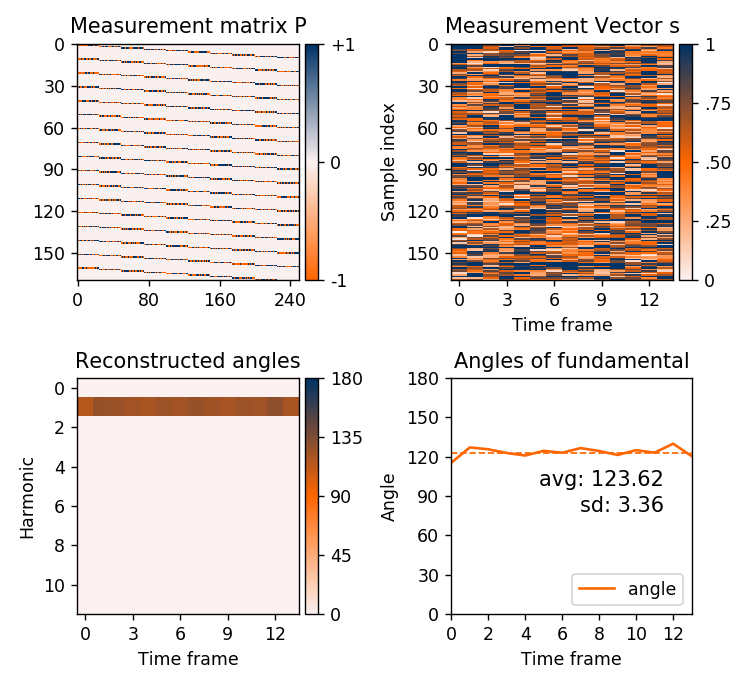

In [46]:
show_plot()

## Visit our department

<img style="float: right;" src="figures/tui-small.png" width=300>

Electronic Measurements and Signal Processing group  
Technische Universität Ilmenau  

www.tu-ilmenau.de/it-ems

http://github.com/EMS-TU-Ilmenau

## Contact us
christoph.wagner@tu-ilmenau.de  
(+49) 3677 - 69 4274

http://github.com/ChristophWWagner